# Feathering (combination) tests

This notebook presents a series of experiments in single-dish + interferometer combination on "realistic" data.

We're "observing" at 2mm, so a 12m dish has FWHM=40" and a 9m baseline has (theoretical) FWHM 56", assuming (incorrectly...) a gaussian beam

In [1]:
# ipython notebook setup:
%matplotlib inline

In [2]:
import image_registration
from astropy import convolution
import numpy as np
import pylab as pl
from uvcombine.uvcombine import feather_kernel, fftmerge

In [3]:
# create an input image with specified parameters
# (this can later be modified - it will be good to examine the effects of
# different power laws, different types of input...)
# We're assuming a scale of 1"/pixel for this example
np.random.seed(0)
imsize = 512
im = image_registration.tests.make_extended(imsize=imsize, powerlaw=1.5)

### Input ###
This is the input image along with its histogram.

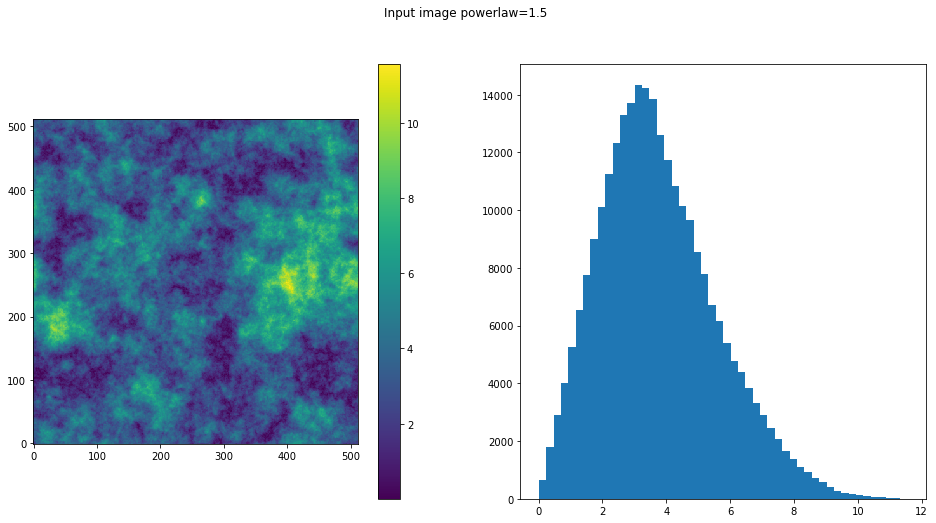

In [4]:
# for each step, we'll save a figure
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.subplot(1,2,2)
pl.hist(im.ravel(), bins=50)
pl.suptitle("Input image powerlaw=1.5")
pl.savefig("inputimage_pl1.5.png")

In [5]:
ygrid, xgrid = np.indices(im.shape, dtype='float')
rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5

In [6]:
# Create a UV sampling mask.
# This removes all large-angular scale (r<8) features *in UV space* and all
# small angular scales.
# In fourier space, r=0 corresponds to the DC component
# r=1 corresponds to the full map (one period over that map)
# r=256 is the smallest angular scale, which is 2 pixels (nyquist sampling....?)
# We're assuming a pixel scale of 1" / pixel
# therefore 56" corresponds to 9m at 2mm (i.e., nearly the closest spacing possible for 7m)
# We cut off the "interferometer" at 2.5" resolution
largest_scale = 56.
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

### Synthetic Perfect Interferometer ###
The synthetic interferometer's UV coverage map (it's a perfect interferometer)

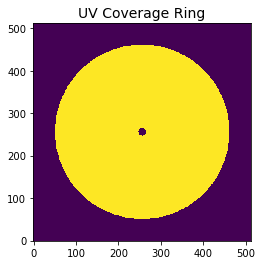

In [7]:
pl.clf()
pl.imshow(ring)
pl.title("UV Coverage Ring")
pl.savefig("uvcoverage_ring.png")

In [8]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

The interferometric image does not preserve total flux, as expected.  Note that the mean of the histogram is shifted.

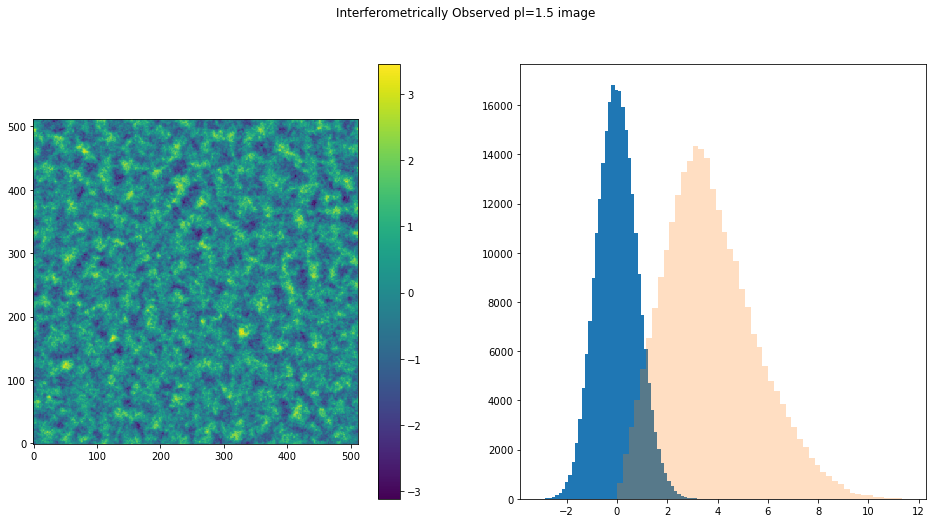

In [9]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im_interferometered.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Interferometrically Observed pl=1.5 image")
pl.subplot(1,2,2)
pl.hist(im_interferometered.real.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.savefig("interf_image_pl1.5.png")

The residual of the original image minus the interferometrically observed image.  The large scales and noise are preserved.

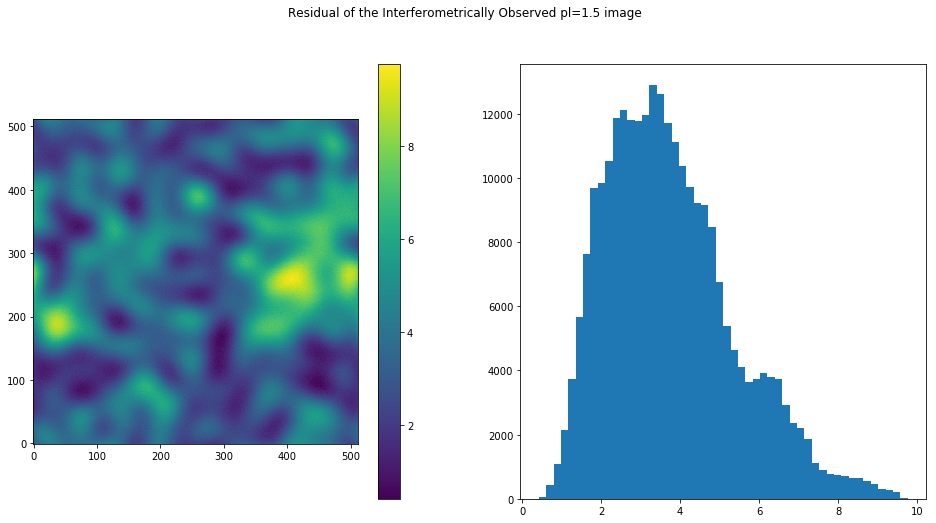

In [10]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im-im_interferometered.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Residual of the Interferometrically Observed pl=1.5 image")
pl.subplot(1,2,2)
pl.hist((im-im_interferometered.real).ravel(), bins=50)
pl.savefig("interf_image_pl1.5_residual.png")

### Synthetic Single Dish ###
The single dish map is just a convolution of the original data with a Gaussian beam.  It preserves flux but loses small scales.

In [11]:
# create the single-dish map by convolving the image with a FWHM=40" kernel
# (this interpretation is much easier than the sharp-edged stuff in fourier
# space because the kernel is created in real space)
lowresfwhm = 40
singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel(lowresfwhm/2.35),
                                         boundary='fill', fill_value=im.mean())

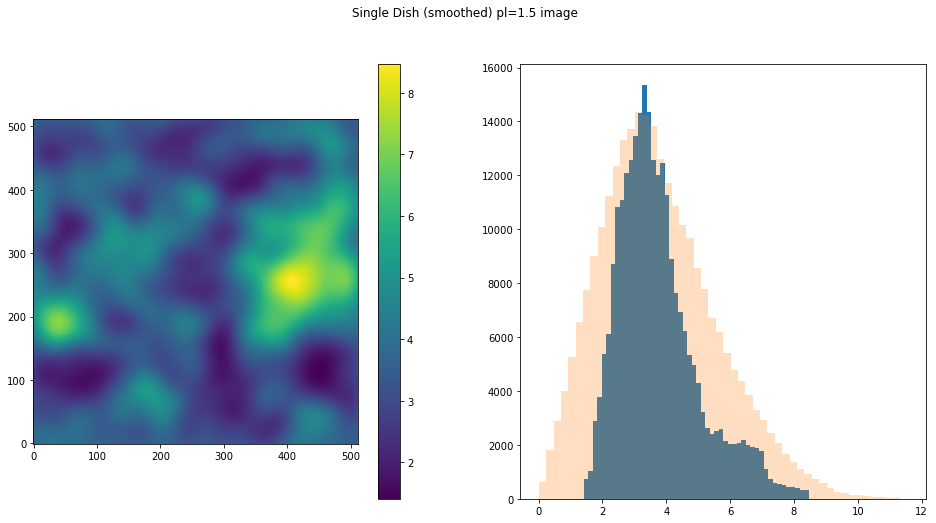

In [12]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(singledish_im, cmap='viridis')
pl.colorbar()
pl.subplot(1,2,2)
pl.hist(singledish_im.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.suptitle("Single Dish (smoothed) pl=1.5 image")
pl.savefig("singledish_image_pl1.5.png")

With this setup, the single dish data looks like a decent match to the interferometer residual.

In [13]:
singledish_kernel = convolution.Gaussian2DKernel(lowresfwhm/2.35, x_size=im.shape[1], y_size=im.shape[0])
singledish_kernel_fft = np.fft.fft2(singledish_kernel)

### The single dish in Fourier space ###
We show the single dish beam in Fourier space with the interferometer coverage range overlaid

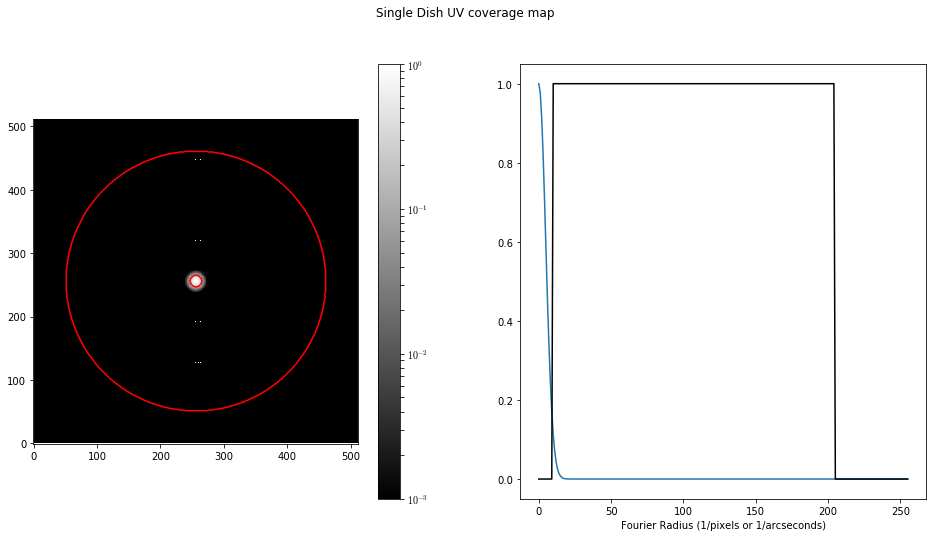

In [14]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(np.fft.fftshift(np.abs(singledish_kernel_fft)), cmap='gray',
          norm=pl.matplotlib.colors.LogNorm(),
          vmin=1e-3,
         )
pl.colorbar()
pl.contour(ring, levels=[0.5], colors=['r','r'])
pl.suptitle("Single Dish UV coverage map")
pl.subplot(1,2,2)
pl.plot(np.fft.fftshift(np.abs(singledish_kernel_fft))[int(im.shape[0]/2),int(im.shape[0]/2):])
pl.plot(ring[int(im.shape[0]/2),int(im.shape[0]/2):], color='k')
pl.xlabel("Fourier Radius (1/pixels or 1/arcseconds)")
pl.savefig("singledish_uvcoverage.png")

In [15]:
# pixel scale can be interpreted as "arcseconds"
# then, fwhm=40 means a beam fwhm of 40"
pixscale = 1
lowresfwhm = 40
nax1,nax2 = im.shape
kfft, ikfft = feather_kernel(nax2, nax1, lowresfwhm, pixscale,)

In [16]:
# Feather the interferometer and single dish data back together
# This uses the naive assumptions that CASA uses
# However, there are a few flags that can be played with.
# None of them do a whole lot, though there are good theoretical
# reasons to attempt them.
im_hi = im_interferometered.real
im_low = singledish_im
lowresscalefactor=1
replace_hires = False
highpassfilterSD = False
deconvSD = False
highresscalefactor=1
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         highpassfilterSD=highpassfilterSD,
                         deconvSD=deconvSD,
                        )

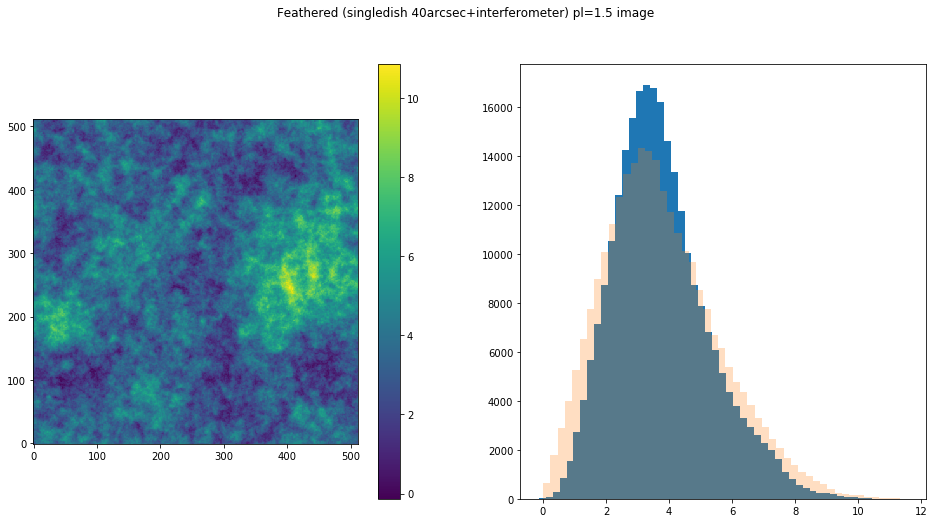

In [17]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.hist(combo.real.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.savefig("feathered_image_pl1.5.png")

This image looks pretty close to the original, but the peaks and valleys certainly are not recovered (the contrast is reduced compared to the original).

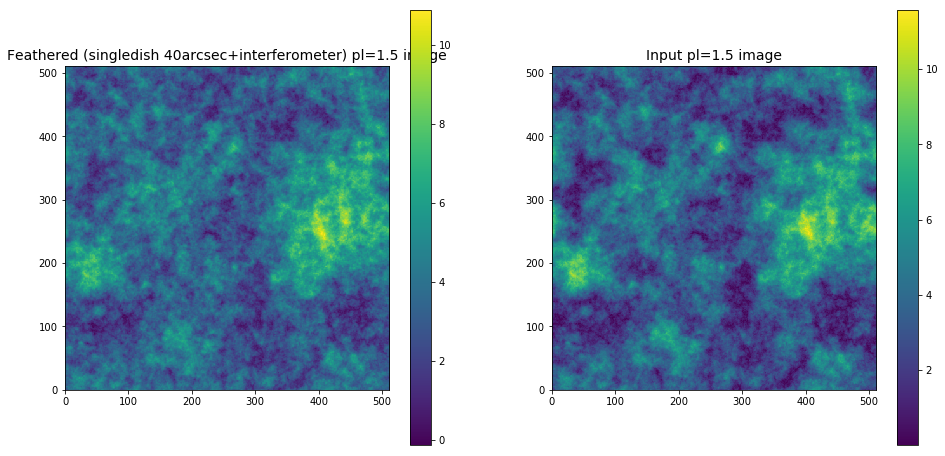

In [18]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")

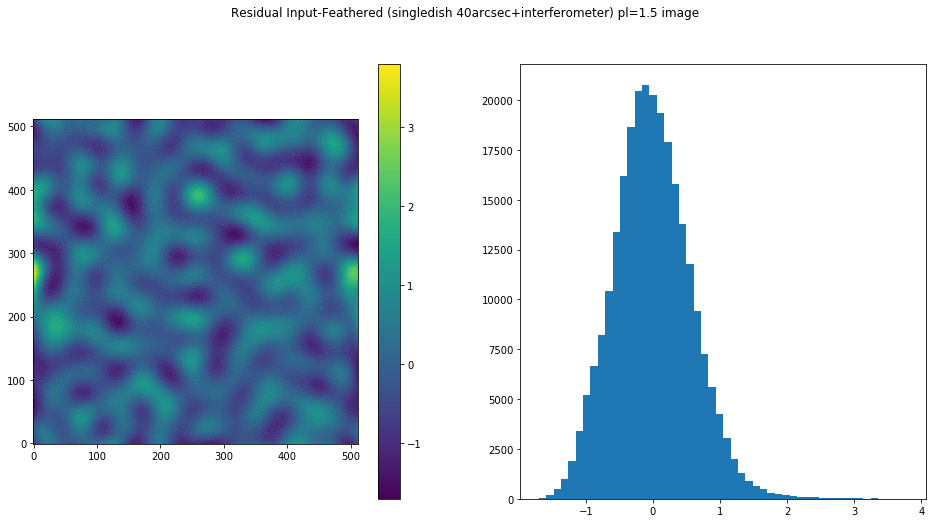

In [19]:
# Residuals (original minus feathered)
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im-combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Residual Input-Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.hist((im-combo.real).ravel(), bins=50)
pl.savefig("residual_feathered_image_pl1.5.png")

If we repeat the same experiment again, but with the shortest baseline at 12m instead of 9m, the results are noticeably worse:

In [20]:
largest_scale = 42. # (1.22 * 2*u.mm/(12*u.m)).to(u.arcsec, u.dimensionless_angles())
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

In [21]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

In [22]:
im_hi = im_interferometered.real
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         highpassfilterSD=highpassfilterSD,
                         deconvSD=deconvSD,
                        )

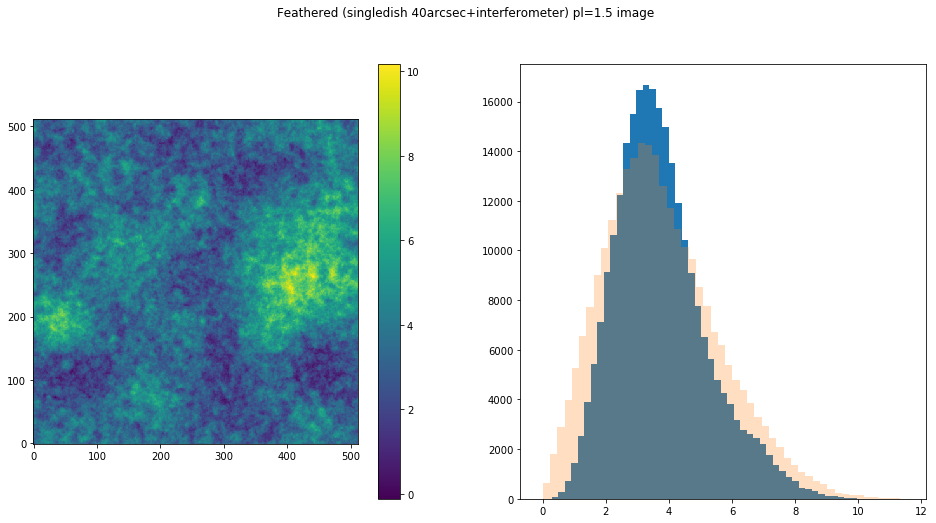

In [23]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.hist(combo.real.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.savefig("feathered_image_pl1.5_12mshort.png")

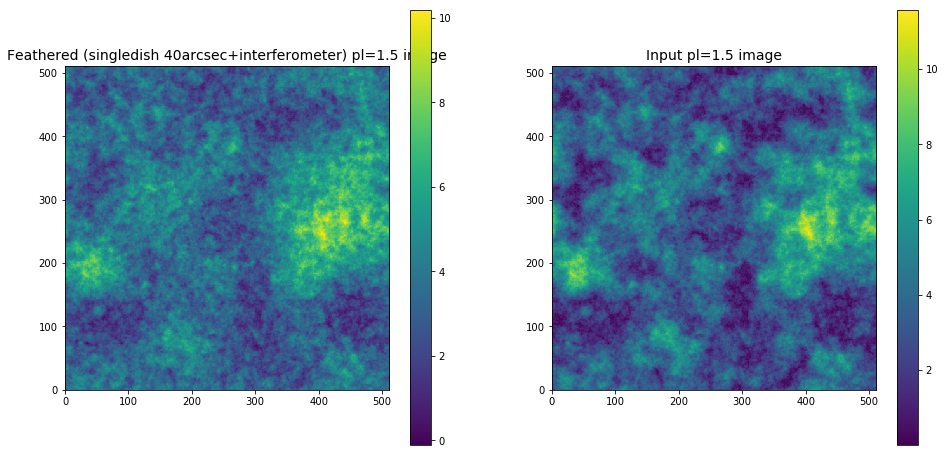

In [24]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")

A more realistic interferometer would be helpful.  There is always some tapering or some change of weights between baseline lengths, and that could have a substantial effect.

## Can we have an immerge-like capability in uvcombine? ##

We made the `feather_compare` function to try to determine the relative scaling factor between the interferometer and single-dish images.  In this section, we'll show that for theoretically perfect data, the approach works.

Because of the design of `feather_compare`, we need to assign FITS headers to our datasets.

In [25]:
from astropy.io import fits

In [26]:
from uvcombine.uvcombine import feather_compare
from astropy import units as u

In [27]:
print("Scales to compare: {0}-{1}".format(lowresfwhm*u.arcsec, largest_scale*u.arcsec))

Scales to compare: 40.0 arcsec-42.0 arcsec


For the hypothetical interferometer we used most recently, there is effectively no overlap.  This is worthless and should NOT be used with this method!  Instead, we can create a new "interferometric" image with some overlap, say LAS=80.

In [28]:
# See above
largest_scale = 80.
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

In [29]:
print("Scales to compare: {0}-{1}".format(lowresfwhm*u.arcsec, largest_scale*u.arcsec))

Scales to compare: 40.0 arcsec-80.0 arcsec


In [30]:
header = fits.Header({'CRVAL1':0.0, 'CRVAL2':0.0, 'CDELT1':1./3600., 'CDELT2':1./3600., 'CRPIX1':1.0, 'CRPIX2':1.0,
                      'CTYPE1':'GLON-CAR', 'CTYPE2':'GLAT-CAR'})
sd_hdu = fits.PrimaryHDU(data=singledish_im, header=header)
intf_hdu = fits.PrimaryHDU(data=im_interferometered.real, header=header)

We'll exhibit a few parameters.  

First, `beam_divide_lores` is a fourier-space deconvolution to try to remove the effect of the single-dish beam in foureir space.  We'll start by leaving this *off*.

Scales to compare: 40.0 arcsec-80.0 arcsec
Reported statistics of the ratio of the high-res to low-res data: {'std_sc': 2.5023963895763988, 'mean': 5.4294552284964572, 'median': 4.2881870546378096, 'mean_sc': 4.5096867850408033, 'std': 5.0921932337657898, 'median_sc': 4.0593122713016863}


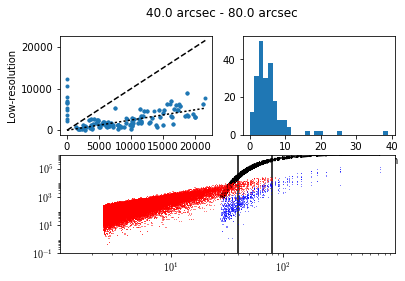

In [31]:
print("Scales to compare: {0}-{1}".format(lowresfwhm*u.arcsec, largest_scale*u.arcsec))
stats = feather_compare(intf_hdu,
                        sd_hdu,
                        SAS=lowresfwhm*u.arcsec,
                        LAS=largest_scale*u.arcsec,
                        lowresfwhm=lowresfwhm*u.arcsec,
                        beam_divide_lores=False,
                       )
# fix the last plot a little
pl.gca().set_ylim(1e-1, 1e6)
print("Reported statistics of the ratio of the high-res to low-res data:", stats)

You can see the result, the high-res is over-compsenated by a factor of 3-6 or so.  The black line in the lower panel shows the effect of the beam in fourier space: it suppresses the intensity.

We can also see that this is a frustratingly noisy process.

Scales to compare: 40.0 arcsec-80.0 arcsec


/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:1182: RuntimeWarning: divide by zero encountered in true_divide
  fft_lo_deconvolved = fft_lo / kfft
/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:1182: RuntimeWarning: invalid value encountered in true_divide
  fft_lo_deconvolved = fft_lo / kfft


Reported statistics of the ratio of the high-res to low-res data: {'std_sc': 0.41573193856086071, 'mean': 0.98526361606162927, 'median': 0.90801615437528671, 'mean_sc': 0.89510319122828286, 'std': 0.71397592478891414, 'median_sc': 0.89369186172535076}


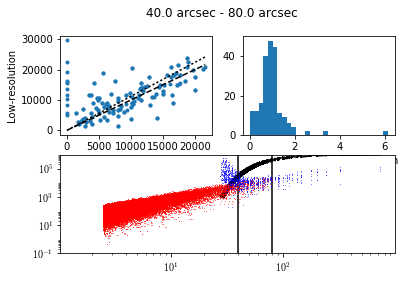

In [32]:
print("Scales to compare: {0}-{1}".format(lowresfwhm*u.arcsec, largest_scale*u.arcsec))
stats = feather_compare(intf_hdu,
                        sd_hdu,
                        SAS=lowresfwhm*u.arcsec,
                        LAS=largest_scale*u.arcsec,
                        lowresfwhm=lowresfwhm*u.arcsec,
                        beam_divide_lores=True,
                       )
# fix the last plot a little
pl.gca().set_ylim(1e-1, 1e6)
print("Reported statistics of the ratio of the high-res to low-res data:", stats)

Now the match is better, but still unfortunately pretty awful because of the noise.  The histogram shows us why: there are $\lesssim100$ points being compared between the two data sets.

We can also see what the 'real' image is supposed to look like in this space as compared with the single-dish and interferometer image:

(0.001, 100000.0)

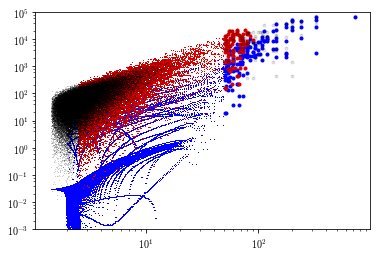

In [33]:
inp_fft = np.fft.fftshift(np.fft.fft2(im))
sd_fft = np.fft.fftshift(np.fft.fft2(singledish_im.real))
intf_fft = np.fft.fftshift(np.fft.fft2(im_interferometered.real))
nax2,nax1 = im.shape
yy,xx = np.indices([nax2, nax1])
rr = ((xx-(nax1-1)/2.)**2 + (yy-(nax2-1)/2.)**2)**0.5
angscales = nax1/rr * pixscale*u.arcsec
largescales = angscales > 50*u.arcsec
pl.loglog(angscales.to(u.arcsec).value.flat, inp_fft.real.flat, 'k,', alpha=0.1, zorder=2)
pl.loglog(angscales.to(u.arcsec).value.flat, intf_fft.real.flat, 'r,', zorder=1)
pl.loglog(angscales.to(u.arcsec).value.flat, sd_fft.real.flat, 'b,', zorder=-1)

pl.loglog(angscales.to(u.arcsec).value[largescales], inp_fft.real[largescales].flat, 'k.', alpha=0.1, zorder=2)
pl.loglog(angscales.to(u.arcsec).value[largescales], intf_fft.real[largescales].flat, 'r.', zorder=1)
pl.loglog(angscales.to(u.arcsec).value[largescales], sd_fft.real[largescales].flat, 'b.', zorder=-1)

pl.ylim(1e-3, 1e5)

(red = interferometer, blue = single dish, black = "truth")

The above plot looks very messy, but there are a few points worth noting.:

 * the single dish data don't reach 100% flux recovery until a very large scale.  Convolution in this case is *barely* flux conserving.
 * the interferometric data are exactly correct, since they were acquired with an 'ideal' sharply-truncated interferometer

So, the next question: What happens to the resulting image if you get the scale factor wrong?

In [34]:
from uvcombine.uvcombine import feather_simple

In [35]:
combo_correct = feather_simple(intf_hdu,
                               sd_hdu,
                               highresscalefactor=1.0,
                               lowresscalefactor=1.0,
                               lowresfwhm=lowresfwhm*u.arcsec,
                              )                        

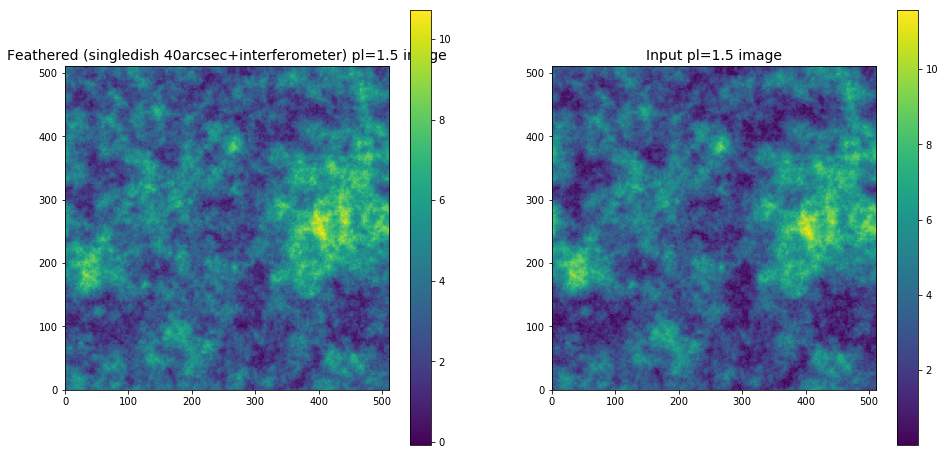

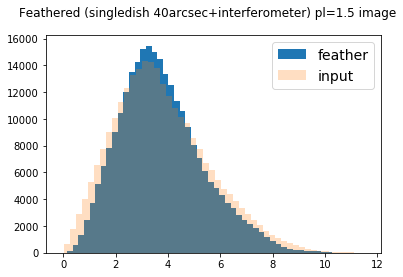

In [36]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo_correct.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")


# Feathered dataset
pl.figure(2).clf()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.hist(combo_correct.real.ravel(), bins=50, label='feather')
_ = pl.hist(im.ravel(), bins=50, alpha=0.25, label='input')
leg = pl.legend(loc='best')

In the "perfect combination, everything exactly right" case, it looks fine.  The images match well and the systematics in the histogram are fairly minor.  We'll now go through a parameter exploration and show how badly things can go:

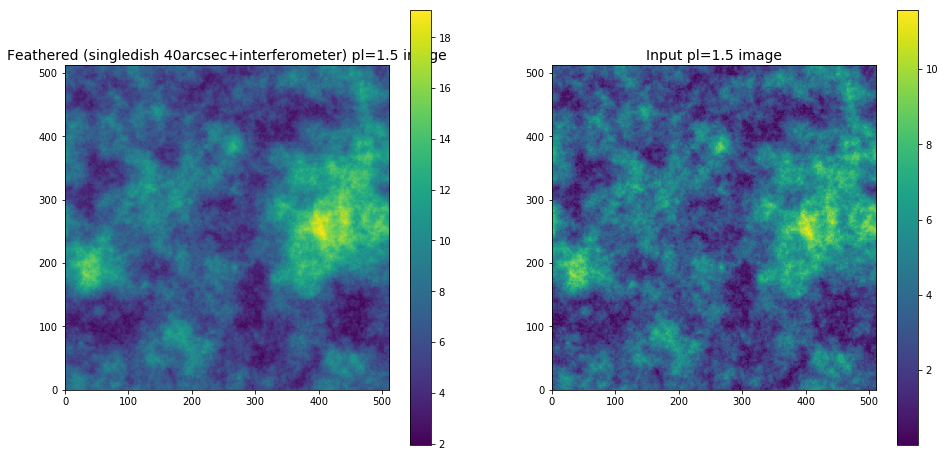

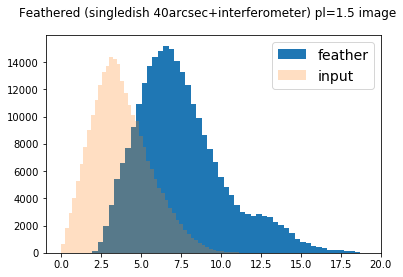

In [37]:
combo_lo_too_hi = feather_simple(intf_hdu,
                               sd_hdu,
                               highresscalefactor=1.0,
                               lowresscalefactor=2.0,
                               lowresfwhm=lowresfwhm*u.arcsec,
                              )

# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo_lo_too_hi.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")


# Feathered dataset
pl.figure(2).clf()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
_ = pl.hist(combo_lo_too_hi.real.ravel(), bins=50, label='feather')
_ = pl.hist(im.ravel(), bins=50, alpha=0.25, label='input')
leg = pl.legend(loc='best')

This is trivial: the flux is systematically shifted if you incorrectly scale the single-dish data.

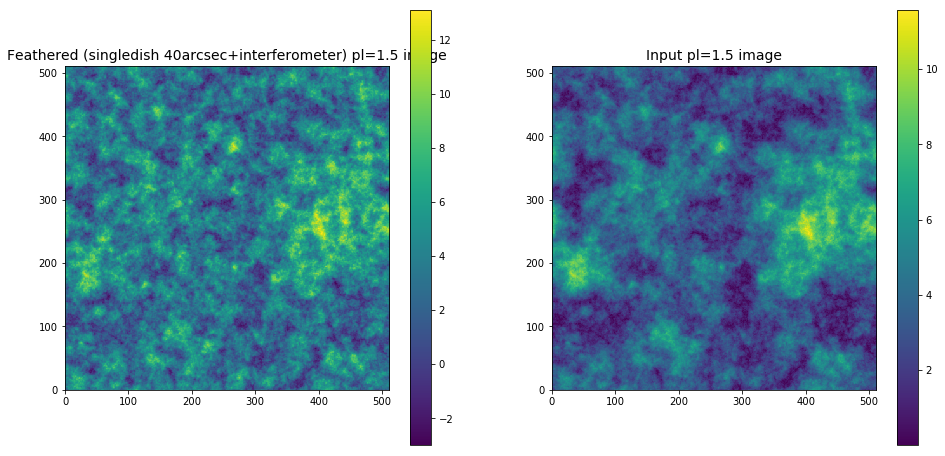

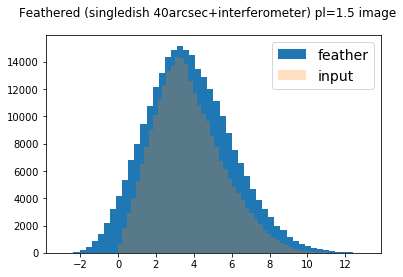

In [38]:
combo_hi_too_hi = feather_simple(intf_hdu,
                               sd_hdu,
                               highresscalefactor=2.0,
                               lowresscalefactor=1.0,
                               lowresfwhm=lowresfwhm*u.arcsec,
                              )

# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo_hi_too_hi.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")


# Feathered dataset
pl.figure(2).clf()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
_ = pl.hist(combo_hi_too_hi.real.ravel(), bins=50, label='feather')
_ = pl.hist(im.ravel(), bins=50, alpha=0.25, label='input')
leg = pl.legend(loc='best')

If the high-resolution data is given too high a scale factor, the overall flux calibration stays approximately correct, but the high-resolution component of the image gets overemphasized, resulting in a spread of the flux distribution.

We can also check the importance and effectiveness of some of the other parameters.

/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:313: RuntimeWarning: divide by zero encountered in true_divide
  lo_conv = fft_lo / kfft
/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:313: RuntimeWarning: invalid value encountered in true_divide
  lo_conv = fft_lo / kfft


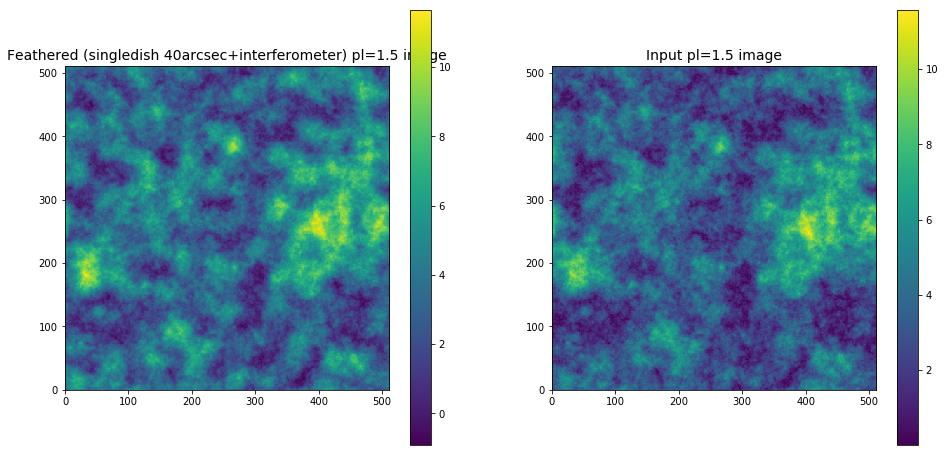

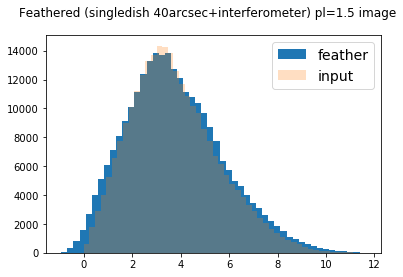

In [39]:
combo_deconv_sd = feather_simple(intf_hdu,
                               sd_hdu,
                               highresscalefactor=1.0,
                               lowresscalefactor=1.0,
                               lowresfwhm=lowresfwhm*u.arcsec,
                                 deconvSD=True,
                              )

# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo_deconv_sd.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")


# Feathered dataset
pl.figure(2).clf()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
_ = pl.hist(combo_deconv_sd.real.ravel(), bins=50, label='feather')
_ = pl.hist(im.ravel(), bins=50, alpha=0.25, label='input')
leg = pl.legend(loc='best')

This works alright, but.... not great.

In principle, deconvolving the single-dish data in fourier space by the convolution kernel used to make the single-dish data should result in a better image.  That it does not probably means the fourier-space deconvolution is simply not reliable enough (it is severely affected by noise at the small end of the beam).

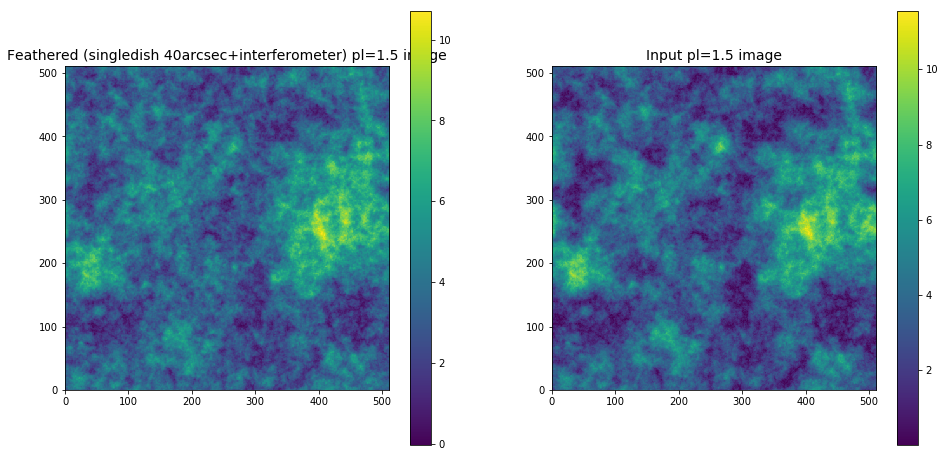

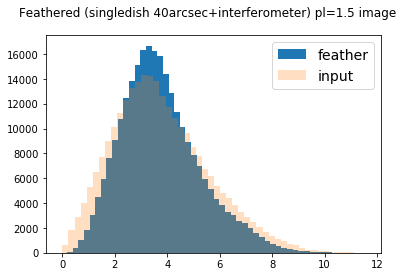

In [40]:
combo_replace_hires_08 = feather_simple(intf_hdu,
                               sd_hdu,
                               highresscalefactor=1.0,
                               lowresscalefactor=1.0,
                               lowresfwhm=lowresfwhm*u.arcsec,
                                 replace_hires=0.8,
                              )

# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo_replace_hires_08.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")


# Feathered dataset
pl.figure(2).clf()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
_ = pl.hist(combo_replace_hires_08.real.ravel(), bins=50, label='feather')
_ = pl.hist(im.ravel(), bins=50, alpha=0.25, label='input')
leg = pl.legend(loc='best')

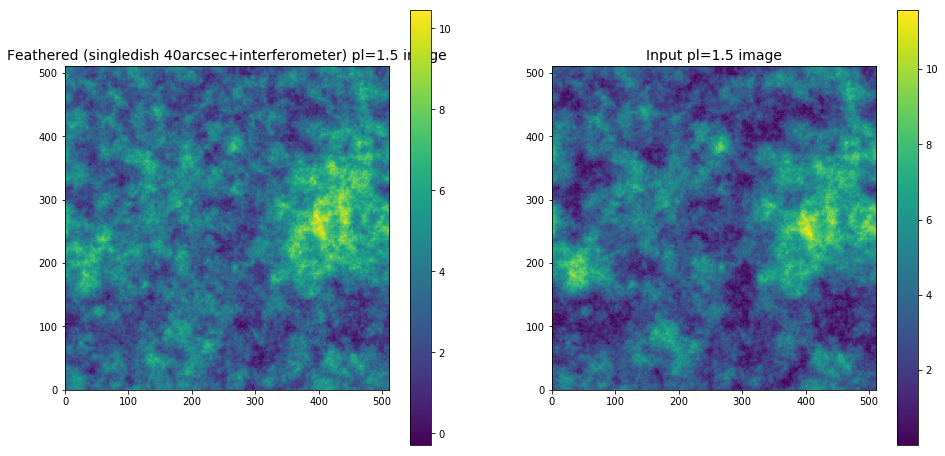

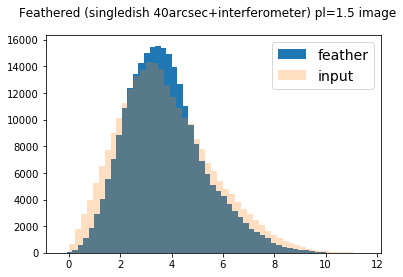

In [41]:
combo_replace_hires_02 = feather_simple(intf_hdu,
                               sd_hdu,
                               highresscalefactor=1.0,
                               lowresscalefactor=1.0,
                               lowresfwhm=lowresfwhm*u.arcsec,
                                 replace_hires=0.2,
                              )

# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo_replace_hires_02.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")


# Feathered dataset
pl.figure(2).clf()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
_ = pl.hist(combo_replace_hires_02.real.ravel(), bins=50, label='feather')
_ = pl.hist(im.ravel(), bins=50, alpha=0.25, label='input')
leg = pl.legend(loc='best')

This approach is fairly suspect.  All it does is take the original single-dish and interferometer images, fourier transform them, then replace the pixels out to a certain radius with the interferometric data.  

The above figures show some case studies.  Can we assess this more quantitatively?

In order to make the test a little more clear, we'll make the interferometer have "perfect" resolution, i.e., no small-angular-scale cutoff.

In [42]:
# See above
largest_scale = 80.
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale))

imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)
intf_hdu = fits.PrimaryHDU(data=im_interferometered.real, header=header)

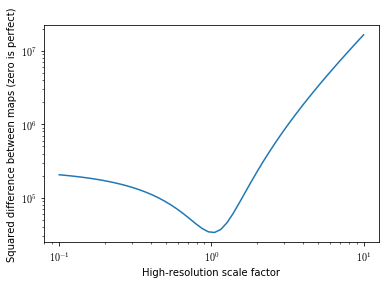

In [43]:
diff_sqs = []
for highresscalefactor in np.logspace(-1,1):
    combo = feather_simple(intf_hdu,
                                   sd_hdu,
                                   highresscalefactor=highresscalefactor,
                                   lowresscalefactor=1.0,
                                   lowresfwhm=lowresfwhm*u.arcsec,
                                  )                        
    diff_sqs.append(((combo.real-im)**2).sum())

pl.loglog(np.logspace(-1,1), diff_sqs)
pl.xlabel("High-resolution scale factor")
pl.ylabel("Squared difference between maps (zero is perfect)")

Next, let's assess how well feather performs as a function of interferomtric LAS.

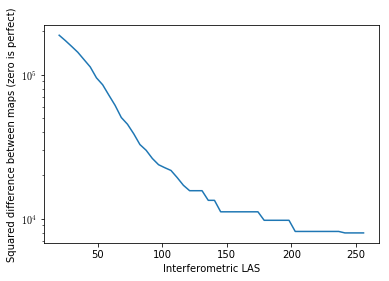

In [44]:
# singledish scale is fixed at 40"
diff_sqs = []

for largest_scale in np.linspace(20,256):

    image_scale = im.shape[0] # assume symmetric (default=256)
    ring = (rr>=(image_scale/largest_scale))

    imfft = np.fft.fft2(im)
    imfft_interferometered = imfft * np.fft.fftshift(ring)
    im_interferometered = np.fft.ifft2(imfft_interferometered)
    intf_hdu = fits.PrimaryHDU(data=im_interferometered.real, header=header)
    
    combo = feather_simple(intf_hdu,
                               sd_hdu,
                               highresscalefactor=1.0,
                               lowresscalefactor=1.0,
                               lowresfwhm=lowresfwhm*u.arcsec,
                              )                        
    diff_sqs.append(((combo.real-im)**2).sum())
    
pl.semilogy(np.linspace(20,256), diff_sqs)
pl.xlabel("Interferometric LAS")
pl.ylabel("Squared difference between maps (zero is perfect)")

Same thing, but with a fixed largest-angular-scale and a changing Single Dish FWHM

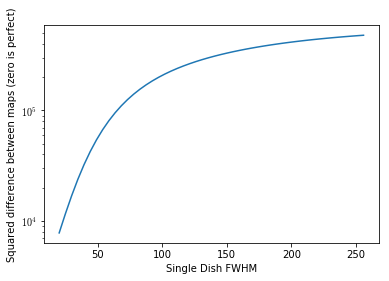

In [45]:
largest_scale = 80 #fixed LAS
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale))

imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)
intf_hdu = fits.PrimaryHDU(data=im_interferometered.real, header=header)


diff_sqs = []

for lowresfwhm in np.linspace(20,256):

    singledish_im = convolution.convolve_fft(im,
                                             convolution.Gaussian2DKernel(lowresfwhm/2.35),
                                             boundary='fill', fill_value=im.mean())
    sd_hdu = fits.PrimaryHDU(data=singledish_im, header=header)

    combo = feather_simple(intf_hdu,
                               sd_hdu,
                               highresscalefactor=1.0,
                               lowresscalefactor=1.0,
                               lowresfwhm=lowresfwhm*u.arcsec,
                              )                        
    diff_sqs.append(((combo.real-im)**2).sum())
    
pl.semilogy(np.linspace(20,256), diff_sqs)
pl.xlabel("Single Dish FWHM")
pl.ylabel("Squared difference between maps (zero is perfect)")

Clearly the single dish FWHM makes a pretty big difference...

# Below here are just experiments #

We used `feather_compare` to directly compare images in fourier space.  What happens if you compare them in image space after filtering?

1. Reset to 120" LAS interferometer and 40" FWHM SD

In [46]:
largest_scale = 120 #fixed LAS
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale))

imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)
im_hi = im_interferometered.real

intf_hdu = fits.PrimaryHDU(data=im_hi, header=header)

lowresfwhm = 40.
singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel(lowresfwhm/2.35),
                                         boundary='fill', fill_value=im.mean())
sd_hdu = fits.PrimaryHDU(data=singledish_im, header=header)

In [47]:
SAS = 40*u.arcsec
LAS = 120*u.arcsec


nax2, nax1 = im.shape
lowresfwhm = u.Quantity(lowresfwhm, u.arcsec)
pixscale = (1*u.arcsec).to(u.deg).value

kfft, ikfft = feather_kernel(nax2, nax1, lowresfwhm, pixscale)
kfft = np.fft.fftshift(kfft)
ikfft = np.fft.fftshift(ikfft)

yy,xx = np.indices([nax2, nax1])
rr = ((xx-(nax1-1)/2.)**2 + (yy-(nax2-1)/2.)**2)**0.5
angscales = nax1/rr * pixscale*u.deg

fft_hi = np.fft.fftshift(np.fft.fft2(np.nan_to_num(im_hi)))
fft_lo = np.fft.fftshift(np.fft.fft2(np.nan_to_num(im_low)))
fft_lo_deconvolved = fft_lo / kfft

min_beam_fraction = 0.05
plot_min_beam_fraction = 0.05
below_beamscale = kfft < min_beam_fraction
below_beamscale_plotting = kfft < plot_min_beam_fraction

mask = (angscales > SAS) & (angscales < LAS) & (~below_beamscale)
assert mask.sum() > 0

hi_img_ring = (np.fft.ifft2(np.fft.fftshift(fft_hi*mask)))
lo_img_ring = (np.fft.ifft2(np.fft.fftshift(fft_lo*mask)))
lo_img_ring_deconv = (np.fft.ifft2(np.fft.fftshift(np.nan_to_num(fft_lo_deconvolved*mask))))
inp_img_ring = np.fft.ifft2(np.fft.fft2(im)*np.fft.fftshift(mask))


/Users/adam/anaconda/envs/astropy35/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/adam/anaconda/envs/astropy35/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/adam/anaconda/envs/astropy35/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in multiply


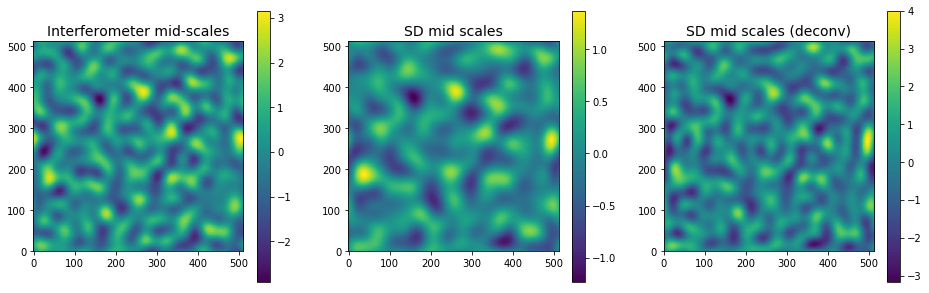

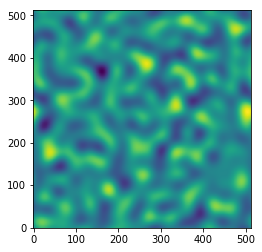

In [48]:
pl.figure(1, figsize=(16,5)).clf()
pl.subplot(1,3,1)
pl.imshow((hi_img_ring).real, cmap='viridis')
pl.colorbar()
pl.title("Interferometer mid-scales")
pl.subplot(1,3,2)
pl.imshow((lo_img_ring).real, cmap='viridis')
pl.colorbar()
pl.title("SD mid scales")
pl.subplot(1,3,3)
pl.imshow((lo_img_ring_deconv).real, cmap='viridis')
pl.colorbar()
pl.title("SD mid scales (deconv)")

pl.figure()
pl.imshow((inp_img_ring).real, cmap='viridis')

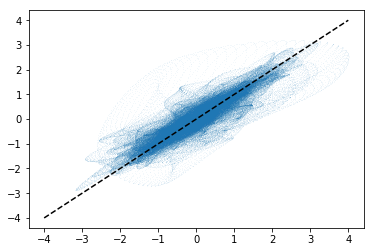

In [49]:
pl.plot((lo_img_ring_deconv.real).ravel(), (hi_img_ring.real).ravel(), ',', alpha=0.05)
pl.plot([-4,4],[-4,4],'k--')

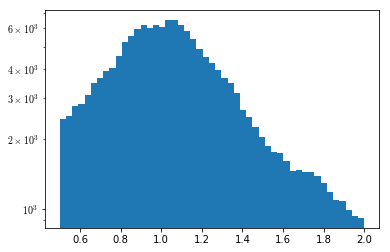

In [50]:
_=pl.hist((lo_img_ring_deconv.real).ravel() / (hi_img_ring.real).ravel(), bins=np.linspace(0.5,2), log=True)

In [51]:
ratio = (lo_img_ring_deconv.real).ravel() / (hi_img_ring.real).ravel()
sd_weighted_mean_ratio = ((lo_img_ring_deconv.real.ravel())**2 * ratio).sum() / ((lo_img_ring_deconv.real.ravel())**2).sum()
sd_weighted_mean_ratio

1.3447937427708105

In [52]:
ratio = (lo_img_ring_deconv.real).ravel() / (hi_img_ring.real).ravel()
intf_weighted_mean_ratio = ((hi_img_ring.real.ravel())**2 * ratio).sum() / ((hi_img_ring.real.ravel())**2).sum()
intf_weighted_mean_ratio

0.96875655130956162

0.95918367346938771

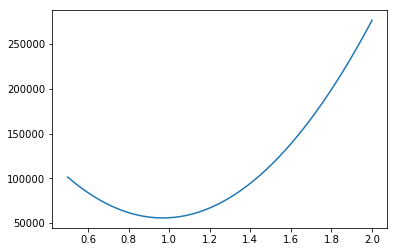

In [53]:
# find the scale factor that minimizes the distance between the images
diffsq = [((lo_img_ring_deconv.real - scf*hi_img_ring.real)**2).sum() for scf in np.linspace(0.5,2.0)]
pl.plot(np.linspace(0.5,2.0), diffsq)
np.linspace(0.5,2.0)[np.argmin(diffsq)]

Try Singular Value Decomposition to determine the scale factor.  Doesn't come very close to a useful answer.

In [54]:
U,S,V = np.linalg.svd(np.array([lo_img_ring_deconv.real.ravel(), hi_img_ring.real.ravel()]).T,
                      full_matrices=False)


In [55]:
V[0,:]/V[1,:]

array([ 1.11226798, -0.89906391])

largest_Scale: 120 lowresfwhm: 40.0 arcsec


/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:1182: RuntimeWarning: divide by zero encountered in true_divide
  fft_lo_deconvolved = fft_lo / kfft
/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:1182: RuntimeWarning: invalid value encountered in true_divide
  fft_lo_deconvolved = fft_lo / kfft


Fourier-based results:  {'std_sc': 0.33375103534510875, 'mean': 1.0356146257713708, 'median': 0.97118904668201989, 'mean_sc': 0.95361023525890731, 'std': 0.60971765685742707, 'median_sc': 0.93787361373685241}


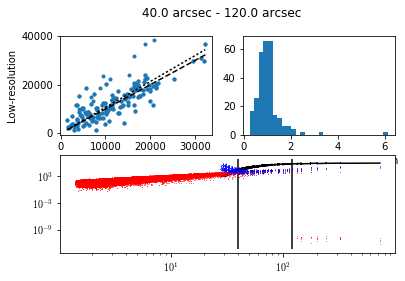

In [56]:
print("largest_Scale: {0} lowresfwhm: {1}".format(largest_scale, lowresfwhm))
stats = feather_compare(intf_hdu,
                        sd_hdu,
                        SAS=u.Quantity(lowresfwhm,u.arcsec),
                        LAS=u.Quantity(largest_scale,u.arcsec),
                        lowresfwhm=u.Quantity(lowresfwhm,u.arcsec),
                        beam_divide_lores=True,
                       )
print("Fourier-based results: ", stats)

Conclusion: Both approaches are noisy, but get to within about 10% of the true scale factor (1.0) in this idealized case.

In [57]:
import uvcombine
import imp
imp.reload(uvcombine.uvcombine)
from uvcombine.uvcombine import angular_range_image_comparison

How well does the angular range image comparison perform for different values of the largest/smallest angular scale?

(assuming we always get the FWHM right)

In [58]:
scalefactors = np.zeros([50,50])
for ii,LAS in enumerate(np.linspace(40,220)*u.arcsec):
    
    for jj,SAS in enumerate(np.linspace(10,100)*u.arcsec):
        try:
            scalefactor = angular_range_image_comparison(intf_hdu,
                                                        sd_hdu,
                                                        SAS=SAS,
                                                        LAS=LAS,
                                                        lowresfwhm=u.Quantity(lowresfwhm,u.arcsec),
                                                        beam_divide_lores=True,
                                                         min_beam_fraction=0.005,
                                                       )
            scalefactors[ii,jj] = scalefactor
        except Exception as ex:
            continue


/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:1292: RuntimeWarning: divide by zero encountered in true_divide
  fft_lo_deconvolved = fft_lo / kfft
/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:1292: RuntimeWarning: invalid value encountered in true_divide
  fft_lo_deconvolved = fft_lo / kfft


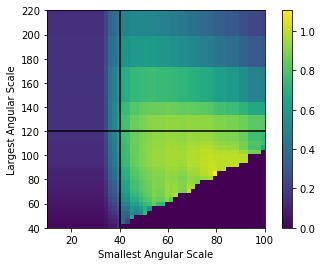

In [59]:
pl.imshow(scalefactors, extent=[10,100,40,220], aspect=1./2); pl.colorbar()
pl.plot([lowresfwhm.value,lowresfwhm.value],[40,220],'k-')
pl.plot([10,100],[largest_scale,largest_scale],'k-')
pl.xlabel("Smallest Angular Scale")
pl.ylabel("Largest Angular Scale")

In this figure, the correct answer is 1.00.  The vertical lines show the "true" LAS and SAS, where SAS = the low resolution FWHM. 

This is a useful summary figure.  As long as you get the largest angular scale approximately correct, to within ~20-30%, you won't miss by more than ~20-30%, but it gets quite bad from there.  It is best to guess too low for the LAS.

You're best guessing too high for the smallest angular scale.  Something like 25-50% larger than the FWHM is much better than using the exact FWHM.

Narrow ranges are noisy, but they appear to do the best in terms of getting the right answer.

In [60]:
import uvcombine
import imp
imp.reload(uvcombine.uvcombine)
from uvcombine.uvcombine import scale_comparison

### Compare the images to the correct answer as a function of scale ###

On its own, this scale comparison doesn't say much, except that the original and 'feathered' images get pretty close but never converge.  This might be useful for comparing a few different methods and seeing how well they each converge.

In [61]:
scales = np.arange(1,64)
chi2s_of_scale = scale_comparison(im, combo.real, scales)

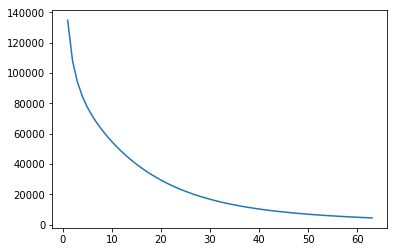

In [62]:
pl.plot(scales, chi2s_of_scale)

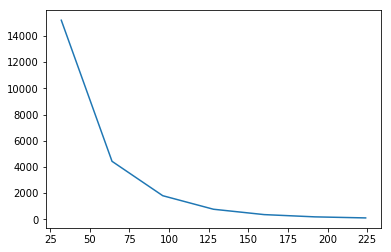

In [63]:
scales_bigsteps = np.arange(32,256,32)
chi2s_of_scale_bigsteps = scale_comparison(im, combo.real, scales_bigsteps)
pl.plot(scales_bigsteps, chi2s_of_scale_bigsteps)

So what happens to convergence as you mess up the parameters (i.e., try to reproduce some immerge behavior, and/or reproduce calibration errors)?

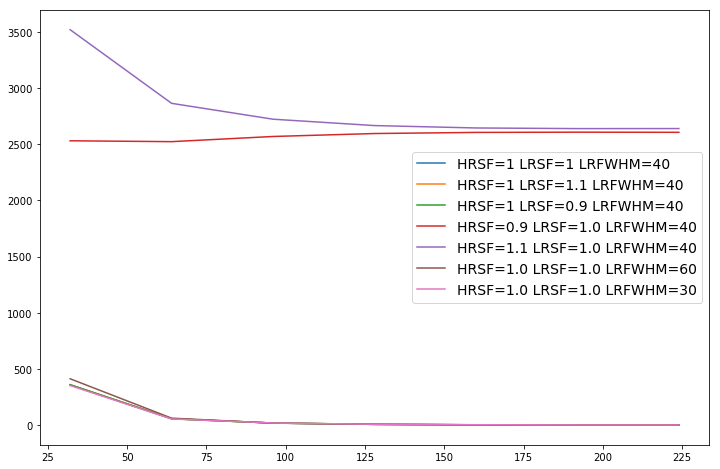

In [66]:
pl.figure(figsize=(12,8))
bad_combos = {}
# correct lowresfwhm is 40
for highresscalefactor, lowresscalefactor, lowresfwhm in (
    (1,1,40),
    (1,1.1,40),
    (1,0.9,40),
    (0.9,1.0,40),
    (1.1,1.0,40),
    (1.0,1.0,60),
    (1.0,1.0,30),
):
        combo_ = feather_simple(intf_hdu,
                                sd_hdu,
                                highresscalefactor=highresscalefactor,
                                lowresscalefactor=highresscalefactor,
                                lowresfwhm=lowresfwhm*u.arcsec,
                               )
        scales_bigsteps = np.arange(32,256,32)
        chi2s_of_scale_bigsteps = scale_comparison(im, combo_.real, scales_bigsteps)
        label = (highresscalefactor,lowresscalefactor,lowresfwhm)
        bad_combos[label] = chi2s_of_scale_bigsteps
        pl.plot(scales_bigsteps, chi2s_of_scale_bigsteps, label="HRSF={0} LRSF={1} LRFWHM={2}".format(*label))
        
pl.legend(loc='best')

Conclusion: difference-squared is not a very useful metric to assess image quality.  The power-spectrum-based comparisons are better.